# Note-4: Human Hematopoiesis ReDeeM 
---

**Author:** Chen Weng

**Date:** December 9, 2023

## Description

This Jupyter Notebook reproduce the all analyses in Main Fig. 2 and Supplementary Fig.4,5, supplementary Data 3

## Related Figures
- Main Fig. 2 
- Supplementary Fig. 4
- Supplementary Fig. 5
- Supplementary Data 3



---

# Install redeemR

In [1]:
#devtools::install_github("chenweng1991/redeemR")

# Import libraries

In [51]:
library(redeemR)
library(ggplot2)
library(dplyr)
library(treeio)
library(ggtree)
library(ggtreeExtra)
library(RColorBrewer)
library(qvalue)
library(Seurat)
library(chromVAR)
library(JASPAR2020)
library(TFBSTools)
library(motifmatchr)
library(BSgenome.Hsapiens.UCSC.hg38)
library(gridExtra)
library(reshape2)
library(ggsci)
library(cols4all)
library(amap)
library(ggdendro)

# Set path

In [5]:
## set main directory to the reproducibility_pub
Dir="/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/reproducibility_pub" # Change this to your actual path **/reproducibility_pub

# Donor Young-1 multiome

## Young-1 cell type clustering

In [6]:
Young1_BMMC_HSPC_multiome_seurat<-readRDS(paste(Dir,"/data/Multiome/DN4_BMMC_HSPC_Multiome_wrapper.filtered.anno",sep="")) 

In [7]:
## Standardize cell types
Young1_BMMC_HSPC_multiome_seurat@meta.data<-Young1_BMMC_HSPC_multiome_seurat@meta.data %>% mutate(STD.CellType=ifelse(STD.CellType=="EryP" & Sample=="DN4_HSPC","MEP",as.character(STD.CellType))) %>%
mutate(STD.CellType=ifelse(STD.CellType=="LMPP" & Sample=="DN4_HSPC","MPP",as.character(STD.CellType)))

In [8]:
## Order cell types for color assignment
Young1_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType<-factor(Young1_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType,
levels=c('LMPP','CMP','MPP','HSC','cDC','Gran','MDP','Mono', 'GMP','NK','ProB','CD8','CD4','B','CLP','pDC','MKP','MEP','EryP'))

In [9]:
## Define a common color code
ColorDic<-data.frame(CellType=c('LMPP','CMP','MPP','HSC',
'cDC','Gran','MDP','Mono', 'GMP',
'NK','ProB','CD8','CD4','B','CLP','pDC',
'MKP','MEP','EryP'),
mc=c(brewer.pal(4,"OrRd"),
brewer.pal(5,"YlOrBr"),
brewer.pal(9,"PuBuGn")[3:9],
brewer.pal(3,"PuRd"))
)       
row.names(ColorDic)<-ColorDic$CellType

In [10]:
AvailableLevel<-intersect(levels(Young1_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType),unique(Young1_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType))
mycolor<-ColorDic[AvailableLevel,"mc"]

## Main Fig. 2c

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


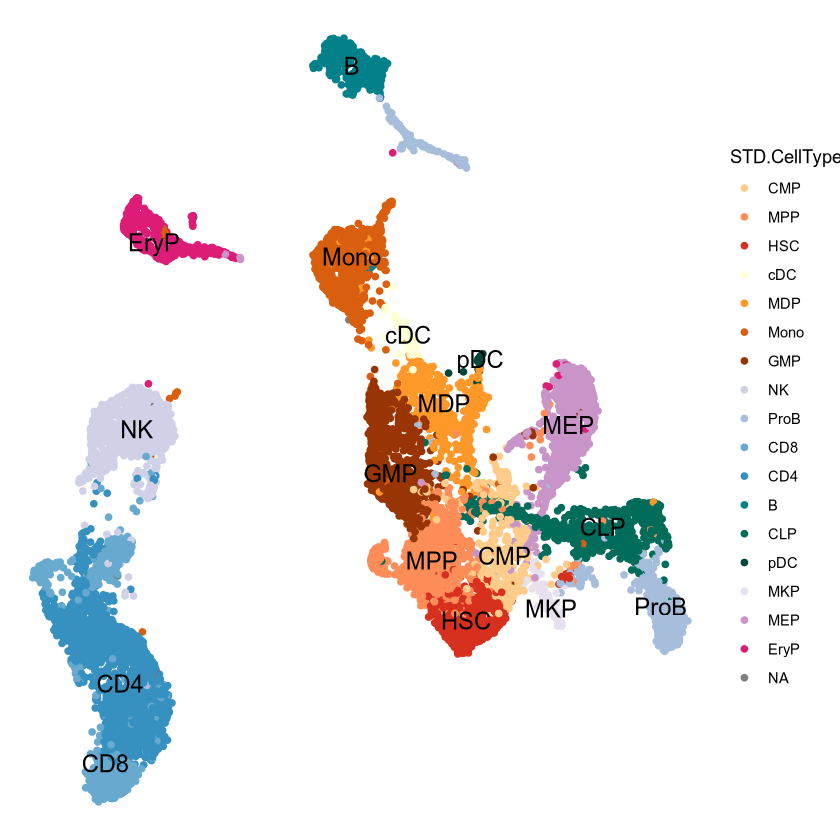

In [33]:
options(repr.plot.width=7, repr.plot.height=7,repr.plot.res=120)
datatoplot<-Tomerge_v2(Young1_BMMC_HSPC_multiome_seurat@reductions$wnn.umap@cell.embeddings,Young1_BMMC_HSPC_multiome_seurat@meta.data[,"STD.CellType",drop=F]) 
label.center<-datatoplot %>% group_by(STD.CellType) %>% dplyr::summarise(x=median(wnnUMAP_1),y=median(wnnUMAP_2))
p<-ggplot(datatoplot)+aes(wnnUMAP_1,wnnUMAP_2,color=STD.CellType)+geom_point(size=1.5) +scale_color_manual(values=mycolor)+theme_void()+geom_text(data=label.center,aes(x=x,y=y,label=STD.CellType),color="black",size=5)#+theme(legend.position="none")
print(p)

## Motif analysis

In [38]:
DefaultAssay(Young1_BMMC_HSPC_multiome_seurat) <- "ATAC"
pwm_set <- getMatrixSet(x = JASPAR2020, opts = list(species = 9606, all_versions = FALSE))

In [39]:
motif.matrix <- CreateMotifMatrix(features = granges(Young1_BMMC_HSPC_multiome_seurat), pwm = pwm_set, genome = 'hg38', use.counts = FALSE)
motif.object <- CreateMotifObject(data = motif.matrix, pwm = pwm_set)
Young1_BMMC_HSPC_multiome_seurat <- SetAssayData(Young1_BMMC_HSPC_multiome_seurat, assay = 'ATAC', slot = 'motifs', new.data = motif.object)

In [41]:
# Run ChromVar
Young1_BMMC_HSPC_multiome_seurat <- RunChromVAR(
  object = Young1_BMMC_HSPC_multiome_seurat,
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



## Main Fig. 2d

In [44]:
options(repr.plot.width=10, repr.plot.height=5,repr.plot.res=300)
motif.name <- ConvertMotifID(Young1_BMMC_HSPC_multiome_seurat, name = 'GATA1')
gata1_gene_plot <- FeaturePlot(Young1_BMMC_HSPC_multiome_seurat, features = "sct_GATA1", reduction = 'wnn.umap',pt.size = 3)+theme_void()
gata1_motif_plot <- FeaturePlot(Young1_BMMC_HSPC_multiome_seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "#A71B4B"), reduction = 'wnn.umap',pt.size = 3)+theme_void()

Warning message:
“Could not find MA0035.4 in the default search locations, found in ‘chromvar’ assay instead”


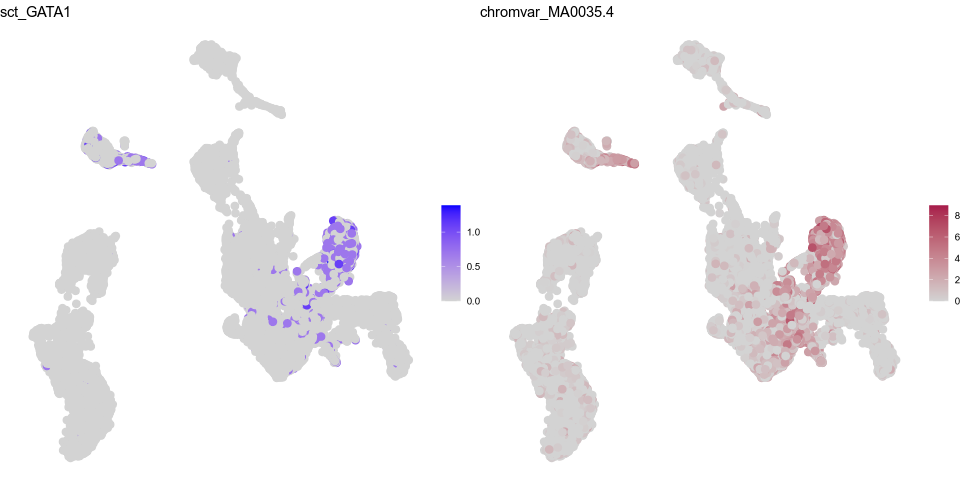

In [53]:
options(repr.plot.width=12, repr.plot.height=6,repr.plot.res=80)
grid.arrange(gata1_gene_plot,gata1_motif_plot,nrow=1)

In [54]:
motif.name <- ConvertMotifID(Young1_BMMC_HSPC_multiome_seurat, name = 'SPI1')
SPI1_gene_plot <- FeaturePlot(Young1_BMMC_HSPC_multiome_seurat, features = "sct_SPI1", reduction = 'wnn.umap',pt.size = 3)+theme_void()
SPI1_motif_plot <- FeaturePlot(Young1_BMMC_HSPC_multiome_seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "#A71B4B"), reduction = 'wnn.umap',pt.size = 3)+theme_void()

Warning message:
“Could not find MA0080.5 in the default search locations, found in ‘chromvar’ assay instead”


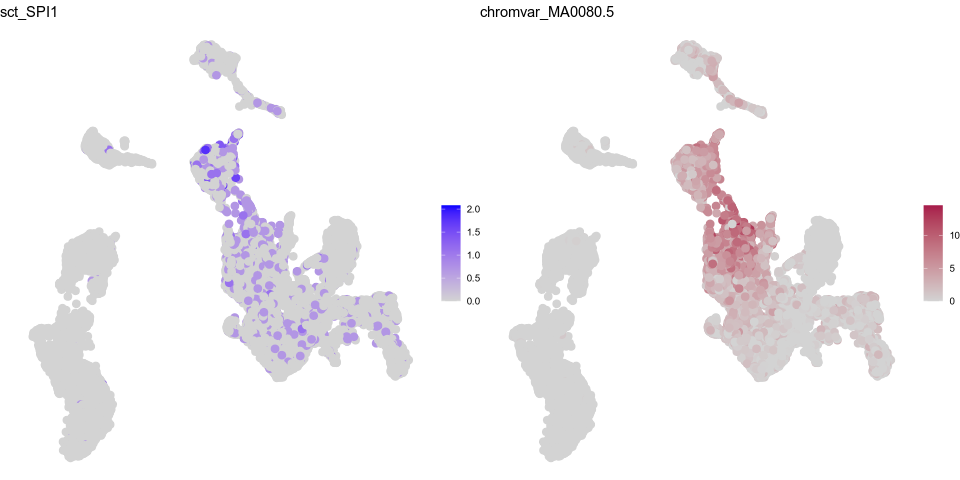

In [55]:
options(repr.plot.width=12, repr.plot.height=6,repr.plot.res=80)
grid.arrange(SPI1_gene_plot,SPI1_motif_plot,nrow=1)

# Donor Young-1 ReDeeM

In [11]:
## Load processed redeemR object
Young1_HSC_HPC_BMMC_mitoTracing.Sensitive<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN4_HSC_HPC_BMMC_mitoTracing.Sensitive",sep="")) 

Warning message:
“Removed 299 rows containing non-finite values (`stat_boxplot()`).”


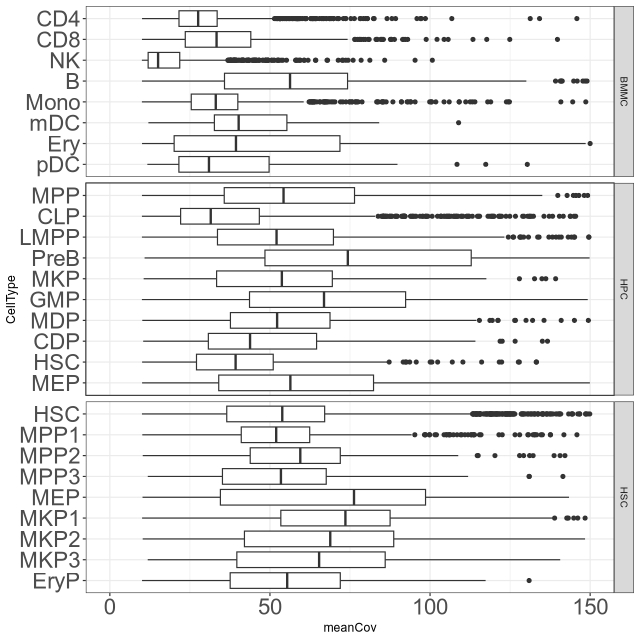

In [13]:
## Coverage by cell type
subset(Young1_HSC_HPC_BMMC_mitoTracing.Sensitive@CellMeta,CellType!=10) %>% ggplot()+aes(CellType,meanCov)+geom_boxplot()+facet_grid(Label~.,space = "free",scales="free")+coord_flip()+ylim(0,150)+theme_bw()+theme(axis.text = element_text(size=20))

In [8]:
## Check variant number
CheckVNumber<-Young1_HSC_HPC_BMMC_mitoTracing.Sensitive@Cts.Mtx.bi %>% rowSums %>% Tomerge_v2(Young1_HSC_HPC_BMMC_mitoTracing.Sensitive@CellMeta,.)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 41 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 41 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 41 rows containing non-finite values (`stat_density()`).”


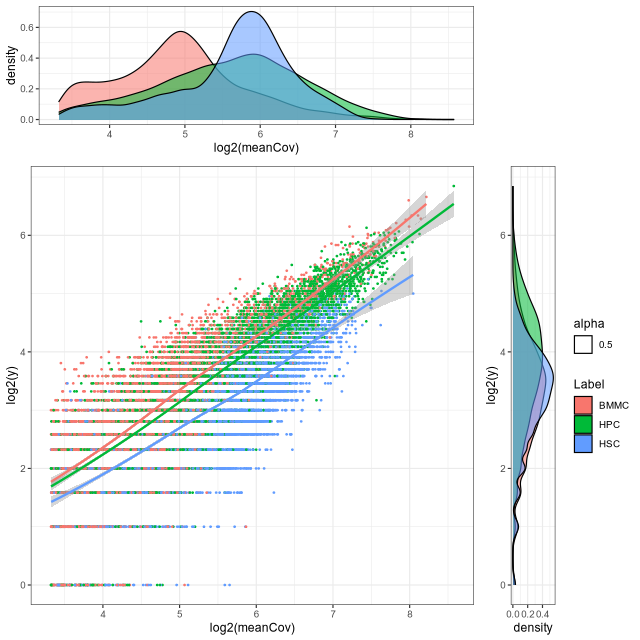

In [9]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=80)
laym<-rbind(c(2,2,2,NA),c(1,1,1,3),c(1,1,1,3),c(1,1,1,3))
p1<-ggplot(CheckVNumber)+aes(log2(meanCov),log2(y),color=Label)+geom_point(size=0.5)+theme_bw()+theme(legend.position="none")+geom_smooth(method = "loess")
p2<-ggplot(CheckVNumber)+aes(log2(meanCov),fill=Label,alpha=0.5)+geom_density()+theme_bw()+theme(legend.position="none")
p3<-ggplot(CheckVNumber)+aes(log2(y),fill=Label,alpha=0.5)+geom_density()+coord_flip()+theme_bw()
grid.arrange(p1,p2,p3,layout_matrix=laym)

## mtDNA mutation burden

In [54]:
## Compute reject rate for normalizing different concensus filtering rate due to sequencing depth
Young1_BMMC_RejectRate<-ComputeRejectRate_legacy(paste(Dir,"/data/redeemV_final/Young1.T1.BMMC.Consensus.final/",sep=""))
Young1_HPC_RejectRate<-ComputeRejectRate_legacy(paste(Dir,"/data/redeemV_final/Young1.T1.HPC.Consensus.final/",sep=""))
Young1_HSC_RejectRate<-ComputeRejectRate_legacy(paste(Dir,"/data/redeemV_final/Young1.T1.HSC.Consensus.final/",sep=""))

This has been deprecated, please use ComputeRejectRate that takes redeemR object as input

This has been deprecated, please use ComputeRejectRate that takes redeemR object as input

This has been deprecated, please use ComputeRejectRate that takes redeemR object as input



In [29]:
Young1_BMMC.HPC.HSC_RejectRate<-rbind(Young1_BMMC_RejectRate %>% mutate(Cell=paste(Cell,"_3",sep="")),
                                   Young1_HPC_RejectRate %>% mutate(Cell=paste(Cell,"_2",sep="")),
                                   Young1_HSC_RejectRate %>% mutate(Cell=paste(Cell,"_1",sep="")))
Young1_BMMC.HPC.HSC_RejectRate<-Young1_BMMC.HPC.HSC_RejectRate %>% tibble::column_to_rownames(var = "Cell")

In [33]:
CheckVNumber$STD.CellType<-plyr::mapvalues(CheckVNumber$CellType,from=c("HSC", "MPP", "MPP1", "MPP2","MPP3", "MKP", "MKP1","MKP2","MKP3", "EryP", "PreB"),to=c("HSC", "MPP", "MPP", "MPP","MMP", "MKP", "MKP","MKP","MKP", "MEP", "ProB"))
CheckVNumber$STD.CellType<-factor(CheckVNumber$STD.CellType,levels=c("HSC","MKP","MPP","CMP","MEP","LMPP","CLP","GMP","MDP","CDP","ProB","Mono","Meg","Ery","mDC","CD4","CD8","NK","B","pDC"))

In [34]:
CheckVNumber<-subset(CheckVNumber,!STD.CellType %in% c("10","ProB"))

In [35]:
CheckVNumber$STD_Cat<-recode(CheckVNumber$STD.CellType,
HSC="Stem",
MPP="EarlyP",CMP="EarlyP",MKP="EarlyP",
MEP="Mye_P",GMP="Mye_P",MDP="Mye_P",CDP="Mye_P",
LMPP="Lym_P",CLP="Lym_P",ProB="Lym_P",
Mono="Mye",Ery="Mye",mDC="Mye",
CD4="Lym",CD8="Lym" ,NK="Lym"  ,B="Lym" ,pDC="Lym") 
CheckVNumber$STD_Cat<-factor(CheckVNumber$STD_Cat,levels=c("Stem","EarlyP","Mye_P","Lym_P","Mye","Lym"))

CheckVNumber$STD_Cat2<-recode(CheckVNumber$STD.CellType,
HSC="Stem",
MPP="EarlyP",CMP="EarlyP",MKP="EarlyP",
MEP="LateP",GMP="LateP",MDP="LateP",CDP="LateP",
LMPP="LateP",CLP="LateP",ProB="LateP",
Mono="mature",Ery="mature",mDC="mature",
CD4="mature",CD8="mature" ,NK="mature"  ,B="mature" ,pDC="mature") 
CheckVNumber$STD_Cat2<-factor(CheckVNumber$STD_Cat2,levels=c("Stem","EarlyP","LateP","mature"))

## Main Fig. 2e

In [ ]:
## Compute mtDNA mutation burden
CheckVNumber<-Tomerge_v2(CheckVNumber,Young1_BMMC.HPC.HSC_RejectRate) %>% mutate(MutationBurden=100*y/(meanCov*Sensitive))

In [50]:
CheckVNumber<-CheckVNumber[!is.na(CheckVNumber$STD.CellType),]

Warning message:
“Removed 238 rows containing non-finite values (`stat_boxplot()`).”


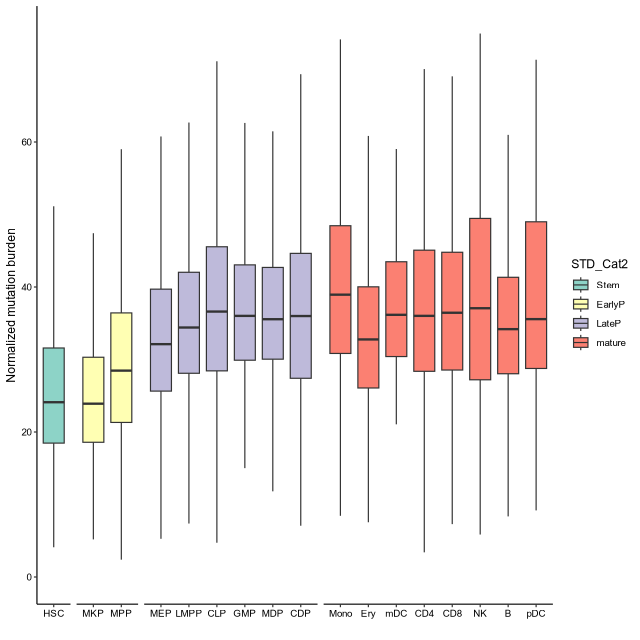

In [51]:
ggplot(CheckVNumber)+aes(STD.CellType,MutationBurden,fill=STD_Cat2)+geom_boxplot(outlier.shape =NA )+ylim(0,75)+
    facet_grid(~STD_Cat2,space = "free",scale="free")+theme_classic()+scale_fill_brewer(palette = "Set3")+theme(strip.text=element_blank(),axis.text = element_text(color="black"),)+labs(x="",y="Normalized mutation burden") 

In [52]:
wilcox.test(subset(CheckVNumber,STD_Cat %in% c("Stem","EarlyP"))$MutationBurden,subset(CheckVNumber,STD_Cat %in% c("Mye_P","Lym_P"))$MutationBurden,alternative = "less")
wilcox.test(subset(CheckVNumber,STD_Cat %in% c("Stem","EarlyP"))$MutationBurden,subset(CheckVNumber,STD_Cat %in% c("Mye","Lym"))$MutationBurden,"less")
wilcox.test(subset(CheckVNumber,STD_Cat %in% c("Mye_P","Lym_P"))$MutationBurden,subset(CheckVNumber,STD_Cat %in% c("Mye","Lym"))$MutationBurden,"less")


	Wilcoxon rank sum test with continuity correction

data:  subset(CheckVNumber, STD_Cat %in% c("Stem", "EarlyP"))$MutationBurden and subset(CheckVNumber, STD_Cat %in% c("Mye_P", "Lym_P"))$MutationBurden
W = 9026543, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0



	Wilcoxon rank sum test with continuity correction

data:  subset(CheckVNumber, STD_Cat %in% c("Stem", "EarlyP"))$MutationBurden and subset(CheckVNumber, STD_Cat %in% c("Mye", "Lym"))$MutationBurden
W = 9878787, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0



	Wilcoxon rank sum test with continuity correction

data:  subset(CheckVNumber, STD_Cat %in% c("Mye_P", "Lym_P"))$MutationBurden and subset(CheckVNumber, STD_Cat %in% c("Mye", "Lym"))$MutationBurden
W = 13467265, p-value = 2.383e-10
alternative hypothesis: true location shift is less than 0


## ReDeeM tree

In [12]:
## Load processed redeemR object
Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN4_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p",sep="")) 

In [13]:
tree<-ggtree(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,branch.length='none')
CellOrder<-subset(tree$data,isTip==TRUE) %>% .[order(.$y),] %>% .$label
VN.summary<-data.frame(VN=rowSums(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)) %>% tibble::rownames_to_column("Cell") %>% mutate(Cell=factor(CellOrder,levels=CellOrder)) %>% mutate(Cell=factor(CellOrder,levels=CellOrder))

## Main Fig. 2b

In [74]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=80)
p<-ggtree(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,branch.length='none',layout="fan",open.angle = 10)+
geom_fruit(data=VN.summary,mapping=aes(y=Cell,
                                           x=VN),
                                           orientation="y",
                                           stat="identity",axis.params=list(axis="x",text.size=6),
                                           geom=geom_bar,pwidth=0.65, fill="gold")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


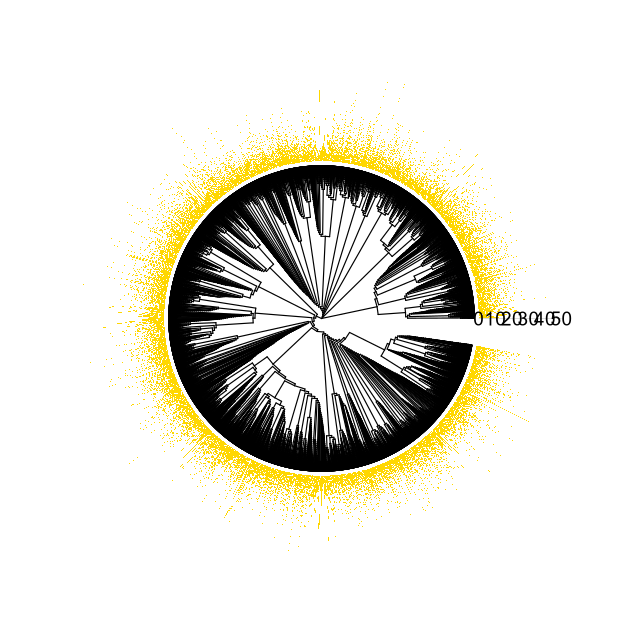

In [75]:
print(p)

## Supplementary Fig. 4a

In [96]:
## Combine the qualified total counts
q_HSPC<-read.table(paste(Dir,"/data/redeemV_final/Young1.T1.HPC.Consensus.final/QualifiedTotalCts",sep=""))
q_BMMC<-read.table(paste(Dir,"/data/redeemV_final/Young1.T1.BMMC.Consensus.final/QualifiedTotalCts",sep=""))
#q_HSC<-read.table(paste(DN4_WD_HSC,"QualifiedTotalCts",sep=""))
q_HSPC$V1<-paste(q_HSPC$V1,"2",sep="_")
q_BMMC$V1<-paste(q_BMMC$V1,"1",sep="_")
QualifiedTotalCts_BMMC_HSPC<-rbind(q_HSPC,q_BMMC)

In [103]:
## Make Cell~Variants depth matrix
colnames(QualifiedTotalCts_BMMC_HSPC)<-c("Cell","Pos","T","LS","S","VS")
Dic<-gsub("Variants","",colnames(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)) %>% substr(.,1,nchar(.)-2) %>% as.integer %>% data.frame(Variants=colnames(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi),Pos=.)
QualifiedTotalCts.subset<-subset(QualifiedTotalCts_BMMC_HSPC,Cell %in% row.names(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)) %>% merge(.,Dic,by="Pos") %>% .[,c("Cell","Variants","S")]
DepthMatrix<-dcast(QualifiedTotalCts.subset,Cell~Variants) %>% tibble::column_to_rownames("Cell") %>% as.matrix
DepthMatrix<-DepthMatrix[row.names(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi),colnames(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)]

Using S as value column: use value.var to override.



In [109]:
## Make allele frequency matrix
AF<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx/DepthMatrix
## Choose top variants to show
VariantsAssign<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@AssignedVariant$Variant.assign.report %>% cbind(.,Size=colSums(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi[,row.names(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@AssignedVariant$Variant.assign.report)]))
Variants2Show<-subset(VariantsAssign,prob>0.3 & Size>20) %>% row.names
Variants2Show<-Variants2Show[-match(c("Variants310TC","Variants3109TC"),Variants2Show)]
AF2show<-AF[,Variants2Show]
dim(AF2show)

[1] 10981   714

In [110]:
## Order by the position of the clade assigned
Variant2Show.info<-VariantsAssign[Variants2Show,] %>% tibble::rownames_to_column("Variant")
Variant.od<-tree$data[,c("node","y")] %>% merge(.,Variant2Show.info,by.x="node",by.y="Edge.Assign") %>% .[order(.$y,decreasing=T),] %>% .$Variant

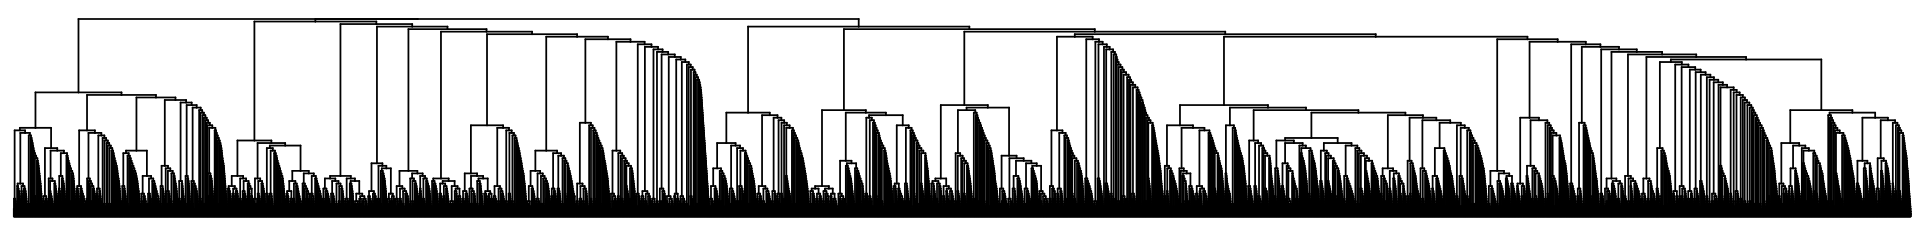

In [113]:
## Plot the tree
options(repr.plot.width=16, repr.plot.height=2,repr.plot.res=120)
ggtree(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,branch.length='none')+ layout_dendrogram()

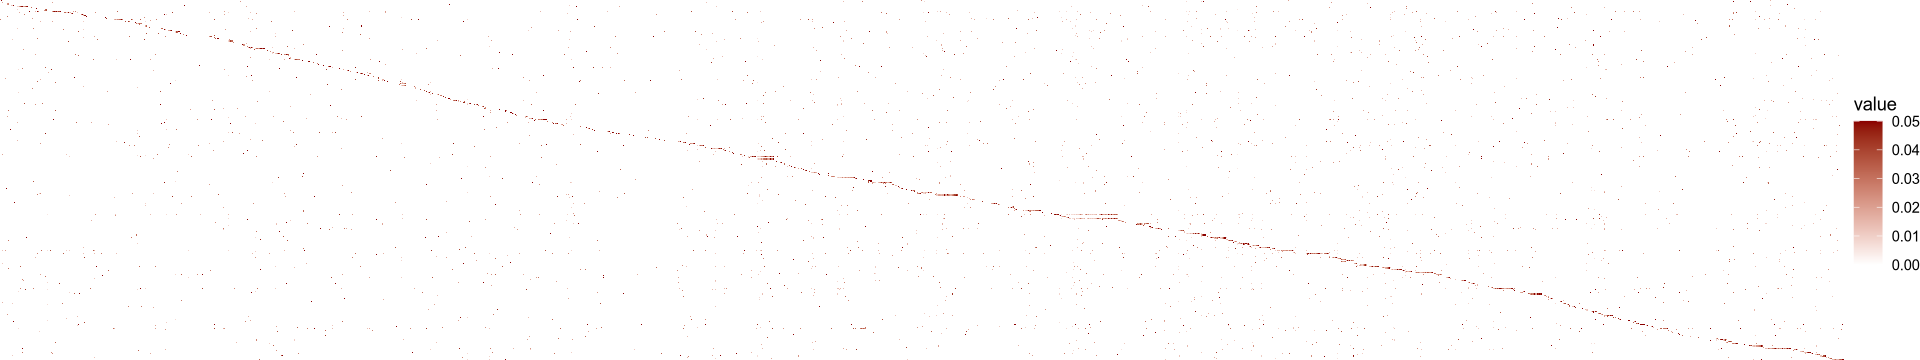

In [111]:
## Plot the variant frequency heatmap
meta<-melt(as.matrix(AF2show))
meta$Var2<-factor(meta$Var2,levels=Variant.od)
meta$Var1<-factor(meta$Var1,levels=CellOrder)
meta$value[which(is.na(meta$value))]<-0
options(repr.plot.width=16, repr.plot.height=3,repr.plot.res=120)
variant_heatmap<-ggplot(meta)+aes(Var1,Var2,fill=value)+geom_tile()+scale_fill_gradient(low="white",high="darkred",limit=c(0,0.05),oob=scales::squish)+
theme(axis.text=element_blank())
variant_heatmap+theme_void()

## Phylogenetic tree clade-based cell type enrichment 

In [116]:
## Compute the Expect cell type proportion
Expect<-table(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$STD.CellType) %>% prop.table
Expect


        CD4          NK        Mono         CD8        EryP           B 
0.188027977 0.072758652 0.061949314 0.081024616 0.055409211 0.046507403 
       ProB         cDC         pDC         MPP         HSC         CLP 
0.067126896 0.004269234 0.003088382 0.068216913 0.050140794 0.075665365 
        GMP         MEP         CMP         MDP         MKP        LMPP 
0.081024616 0.044690708 0.036333909 0.041874830 0.012989372 0.008901808 

In [117]:
## Get unique clades
Unique_Clades<-unique(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$edge[,1])
## Get decendent leaves for each clades
Unique_Clades_Des<-phangorn::Descendants(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo,Unique_Clades,)
## Get decendent cell names for each clades
Unique_Clades_Des_CellNames<-lapply(Unique_Clades_Des,function(x){Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$tip.label[x]}) 
## Get clade sizes
Unique_Clades_Sizes<-data.frame(Clades=Unique_Clades,CladeSize=sapply(Unique_Clades_Des,length))

In [119]:
## Compute the lineage enrichment at tree clade level
clade_lineage_summary<-list()
for(Focus in c("CD4","CD8","NK","B","ProB","CLP","Mono","GMP","MDP","MEP","EryP")){
FCs<-c()
pvalues<-c()
for (i in 1:length(Unique_Clades_Des_CellNames)){
    cells<-Unique_Clades_Des_CellNames[[i]]
    data<-subset(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta,Cell %in% cells)
    x=length(which(data$STD.CellType==Focus))
    n=nrow(data)
    Fold=(x/n)/Expect[Focus]
    md<-binom.test(x,n,Expect[Focus],alternative = "greater")
    pvalue<-md$p.value
    FCs<-c(FCs,Fold)
    pvalues=c(pvalues,pvalue)
}
summary<-data.frame(Clades=Unique_Clades,FCs=FCs,pvalues=pvalues)
clade_lineage_summary<-c(clade_lineage_summary,list(summary))
}
names(clade_lineage_summary)<-c("CD4","CD8","NK","B","ProB","CLP","Mono","GMP","MDP","MEP","EryP")
clade_lineage_summary<-lapply(clade_lineage_summary,function(x){merge(x,Unique_Clades_Sizes,by="Clades")})

In [122]:
## Add FDR
for(i in 1:length(clade_lineage_summary)){
    clade_lineage_summary[[i]]<-clade_lineage_summary[[i]] %>% subset(.,FCs!=0) %>% mutate(FDRs=qvalue(.[,"pvalues"])$qvalues) 
}

## Merge
merge_clade_lineage_summary<-c()
for (i in 1:length(clade_lineage_summary)){
    tmp<-clade_lineage_summary[[i]] %>% mutate(CellType=names(clade_lineage_summary)[[i]])
    merge_clade_lineage_summary<-rbind(merge_clade_lineage_summary,tmp)
}

## Supplementary Data 3

In [127]:
merge_clade_lineage_summary.report<-subset(merge_clade_lineage_summary,FDRs<=0.25 & FCs>2 & CladeSize>=4)

In [136]:
merge_clade_lineage_summary.report %>% .[order(.$FDR),] %>% head # We manually picked some examples from this table and visulized below

,Clades,FCs,pvalues,CladeSize,FDRs,CellType
,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>
28002,13781,18.48454,1.682533e-22,23,2.766651e-19,MEP
49922,15973,18.84296,2.156853e-19,19,1.773297e-16,MEP
66172,17598,19.74354,7.073340e-19,17,3.876986e-16,MEP
59182,16899,18.64668,4.066252e-18,18,1.671573e-15,MEP
62315,11604,12.88316,1.008624e-17,33,3.317035e-15,MEP
76762,18657,19.57901,1.397072e-17,16,3.828764e-15,MEP


## Visualize enriched clades

In [131]:
# Define visualization functions
## Highlight clades on the tree, given tree.data and clade number
HighlightClade<-function(tree.data,clade,l="circular",angle=0){
tree.data2 <- groupClade(tree.data, c(clade))
dt<-data.frame(node=c(clade),name=c(clade))
p<-ggtree(tree.data2,branch.length = "none",aes(color=group),layout = l,open.angle=angle)+geom_cladelab(data=dt,mapping=aes(node=node,label=name))
return(p)
}
## Highlight clades on the UMAP, given mitotracing(older version of redeemR) and clade number and Seurat object
highlightClade_UMAP<-function(mitoTracing,Clade,Seurat){
Cells_hl<-mitoTracing@TREE@phylo$tip.label[phangorn::Descendants(mitoTracing@TREE@phylo,Clade)[[1]]]
datatoplot<-Tomerge_v2(Seurat@reductions$wnn.umap@cell.embeddings,Seurat@meta.data[,"STD.CellType",drop=F]) %>% tibble::rownames_to_column("Cell") %>% 
mutate(Cell=Translate_simple_RNA2ATAC(Cell)) %>% mutate(HL=ifelse(Cell %in% Cells_hl,"Clone","")) 
ggplot(datatoplot)+aes(wnnUMAP_1,wnnUMAP_2)+geom_point(color="grey",size=0.5)+geom_point(data=subset(datatoplot,HL=="Clone"),aes(wnnUMAP_1,wnnUMAP_2),shape=21,color="#B71D3E",fill="#F9A650",size=0.75)+theme_void()
}

## Main Fig. 2f

In [138]:
p.clade1<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,15898,l="circular",angle=10)
p.clade2<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,20835,l="circular",angle=10)
p.clade3<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,13781,l="circular",angle=10)
p.clade4<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,19546,l="circular",angle=10)
p.clade5<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,12464,l="circular",angle=10)
p.clade6<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,15686,l="circular",angle=10)
p.clade7<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,11460,l="circular",angle=10)
p.clade8<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,15907,l="circular",angle=10) 
p.clade9<-HighlightClade(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,17285,l="circular",angle=10) 

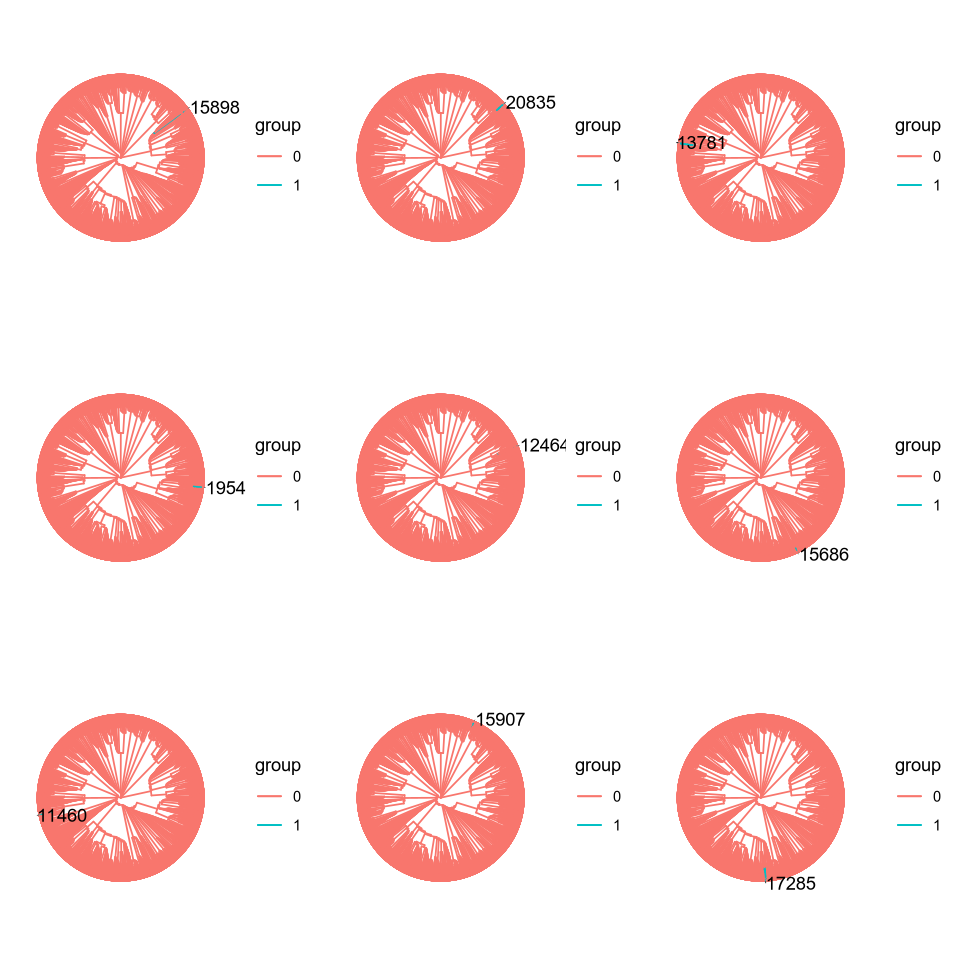

In [142]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=120)
grid.arrange(p.clade1,p.clade2,p.clade3,p.clade4,p.clade5,p.clade6,p.clade7,p.clade8,p.clade9,nrow=3)

In [150]:
ps<-list()
for (clade in c(15898,20835,13781,19546,12464,15686,11460,15907,17285)){
p<-highlightClade_UMAP(mitoTracing=Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj,Clade=clade,Seurat=Young1_BMMC_HSPC_multiome_seurat)
ps<-c(ps,list(p))
}

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3

The following `from` values were not present in `x`: 3



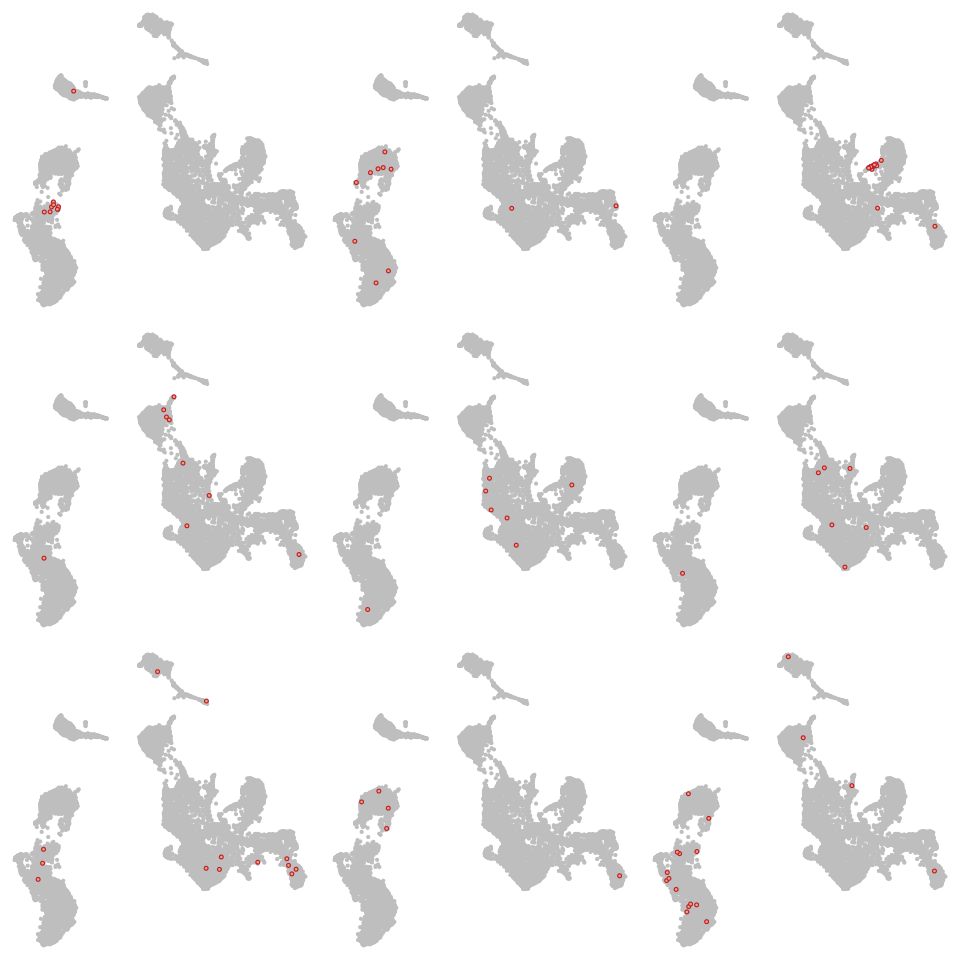

In [152]:
grid.arrange(grobs=ps,nrow=3)

## lineage-biased mtDNA mutations

In [15]:
## Define "linegae", in this context, "lineage" is a differentaion trajectory, such as lymphoind, myeloid, etc
Young1_meta<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta
Young1_meta$Lineage<-dplyr::recode(Young1_meta$STD.CellType,
MK="MKP", 
EryP ="ME",MEP="ME",
HSC="HSCMPP", MPP="HSCMPP",LMPP="HSCMPP", CMP="HSCMPP",
MDP="Mye", GMP="Mye",cDC="Mye", Mono="Mye",
ProB="Lym", CLP="Lym", pDC="Lym",B="Lym", NK="Lym", CD8="Lym", CD4="Lym")

In [16]:
table(Young1_meta$Lineage)


   Lym    Mye     ME HSCMPP    MKP 
  5881   2082   1102   1801    143 

In [17]:
# Compute lineage variants summary
LV<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@GTsummary.filtered %>% merge(.,Young1_meta[,c("Cell","Lineage")]) 
## Make LV.summarise
LV.summarise<-LV %>% group_by(Variants) %>% dplyr::count(Lineage) %>% dcast(Variants~Lineage)
row.names(LV.summarise)<-LV.summarise$Variants
LV.summarise<-LV.summarise[,-1]
LV.summarise[is.na(LV.summarise)]<-0
LV.summarise$sum<-rowSums(LV.summarise)
head(LV.summarise,n=2)

Using n as value column: use value.var to override.



,Lym,Mye,ME,HSCMPP,MKP,sum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000_T_C,2,3,2,3,0,10
10000_G_A,3,4,0,1,0,8


In [18]:
## Calculate expected lineage proportion
Exp<-colSums(LV.summarise[,-6])/sum(colSums(LV.summarise[,-6]))
Exp

Lym        Mye         ME     HSCMPP        MKP 
0.44683654 0.23579579 0.13095419 0.17249475 0.01391872

In [19]:
## A function to test lineage biases
VariantLinBiase.compute<-function(x,alt="greater"){
p1<-binom.test(x[1],x[6],Exp[1],alternative = alt)$p.value
Es1<-(x[1]/x[6])/Exp[1]
p2<-binom.test(x[2],x[6],Exp[2],alternative = alt)$p.value
Es2<-(x[2]/x[6])/Exp[2]
p3<-binom.test(x[3],x[6],Exp[3],alternative = alt)$p.value
Es3<-(x[3]/x[6])/Exp[3]
p4<-binom.test(x[4],x[6],Exp[4],alternative = alt)$p.value
Es4<-(x[4]/x[6])/Exp[4]
p5<-binom.test(x[5],x[6],Exp[5],alternative = alt)$p.value
Es5<-(x[5]/x[6])/Exp[5]
ps<-c(p1,p2,p3,p4,p5)
Ess<-c(Es1,Es2,Es3,Es4,Es5)
return(list(ps,Ess))
}

In [20]:
## Compute lineage enrichment for all mtDNA mutations
LV.summarise.raw<-apply(LV.summarise,1,VariantLinBiase.compute)
LV.summarise.enrich.pvalues<- lapply(LV.summarise.raw,function(x){x[[1]]}) %>% do.call(rbind,.) %>% as.data.frame
LV.summarise.enrich.effectSizes<-lapply(LV.summarise.raw,function(x){x[[2]]}) %>% do.call(rbind,.)  %>% as.data.frame

In [21]:
## Pick top enriched mtDNA mutation examples for visualization
topn=10
Mye.example<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.pvalues$Mye<0.05),] %>% .[order(.$Mye,decreasing=T),] %>% row.names %>% .[1:topn] %>% gsub("_","",.) %>% paste("Variants",.,sep="")
Lym.example<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.pvalues$Lym<0.05),] %>% .[order(.$Lym,decreasing=T),] %>% row.names %>% .[1:topn] %>% gsub("_","",.) %>% paste("Variants",.,sep="")
ME.example<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.pvalues$ME<0.05),] %>% .[order(.$ME,decreasing=T),] %>% row.names %>% .[1:topn] %>% gsub("_","",.) %>% paste("Variants",.,sep="")

In [22]:
## Prepare example data for visualization
Top.Cell.V.mtx<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx[,Mye.example] %>% .[rowSums(.)>0,] 
Highlight.Mye<-apply(Top.Cell.V.mtx,1,function(x){paste(Mye.example[which(x!=0)],collapse="/")}) %>% data.frame(Mye.Highlight=.) %>% tibble::rownames_to_column("ATACName")

Top.Cell.V.mtx<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx[,Lym.example] %>% .[rowSums(.)>0,] 
Highlight.Lym<-apply(Top.Cell.V.mtx,1,function(x){paste(Lym.example[which(x!=0)],collapse="/")}) %>% data.frame(Lym.Highlight=.) %>% tibble::rownames_to_column("ATACName")

Top.Cell.V.mtx<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx[,ME.example] %>% .[rowSums(.)>0,] 
Highlight.ME<-apply(Top.Cell.V.mtx,1,function(x){paste(ME.example[which(x!=0)],collapse="/")}) %>% data.frame(ME.Highlight=.) %>% tibble::rownames_to_column("ATACName")

In [23]:
# Link RNA name with the ATAC name
datatoplot<-Young1_BMMC_HSPC_multiome_seurat@reductions$wnn.umap@cell.embeddings %>% as.data.frame %>% tibble::rownames_to_column("RNAName") %>% mutate(ATACName=Translate_simple_RNA2ATAC(RNAName))
datatoplot2<-merge(datatoplot,Highlight.Mye,by="ATACName",all.x=T) %>% 
merge(.,Highlight.Lym,by="ATACName",all.x=T) %>% merge(.,Highlight.ME,by="ATACName",all.x=T) 
head(datatoplot2,n=2)

The following `from` values were not present in `x`: 3



,ATACName,RNAName,wnnUMAP_1,wnnUMAP_2,Mye.Highlight,Lym.Highlight,ME.Highlight
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,AAACAAGCAAACTAAC_1,GGCTAGTGTTGAGGTC-1,-8.931378,-4.286667,NA,NA,NA
2,AAACAAGCAAGGGAGC_1,GGCTAGTGTCTCACTG-1,-7.428356,-8.479123,NA,NA,NA


## Supplementary Fig. 4b

In [24]:
p1<-ggplot(datatoplot2)+aes(wnnUMAP_1,wnnUMAP_2)+geom_point(color="grey85",size=0.25)+geom_point(shape=24,data=subset(datatoplot2,! is.na(Mye.Highlight)),aes(wnnUMAP_1,wnnUMAP_2,color=Mye.Highlight),size=1.2)+
theme_classic()+scale_color_discrete_c4a_cat(palette = "kelly")+ggtitle("Myeloid lineage overrepresented variants")+theme(plot.title = element_text(hjust = 0.5,colour = "black"))
p2<-ggplot(datatoplot2)+aes(wnnUMAP_1,wnnUMAP_2)+geom_point(color="grey85",size=0.25)+geom_point(shape=24,data=subset(datatoplot2,! is.na(Lym.Highlight)),aes(wnnUMAP_1,wnnUMAP_2,color=Lym.Highlight),size=1.2)+
theme_classic()+scale_color_discrete_c4a_cat(palette = "kelly")+ggtitle("Lymphoid lineage overrepresented variants")+theme(plot.title = element_text(hjust = 0.5,colour = "black"))
p3<-ggplot(datatoplot2)+aes(wnnUMAP_1,wnnUMAP_2)+geom_point(color="grey85",size=0.25)+geom_point(shape=24,data=subset(datatoplot2,! is.na(ME.Highlight)),aes(wnnUMAP_1,wnnUMAP_2,color=ME.Highlight),size=1.2)+
theme_classic()+scale_color_discrete_c4a_cat(palette = "kelly")+ggtitle("Meg/Ery lineage overrepresented variants")+theme(plot.title = element_text(hjust = 0.5,colour = "black"))

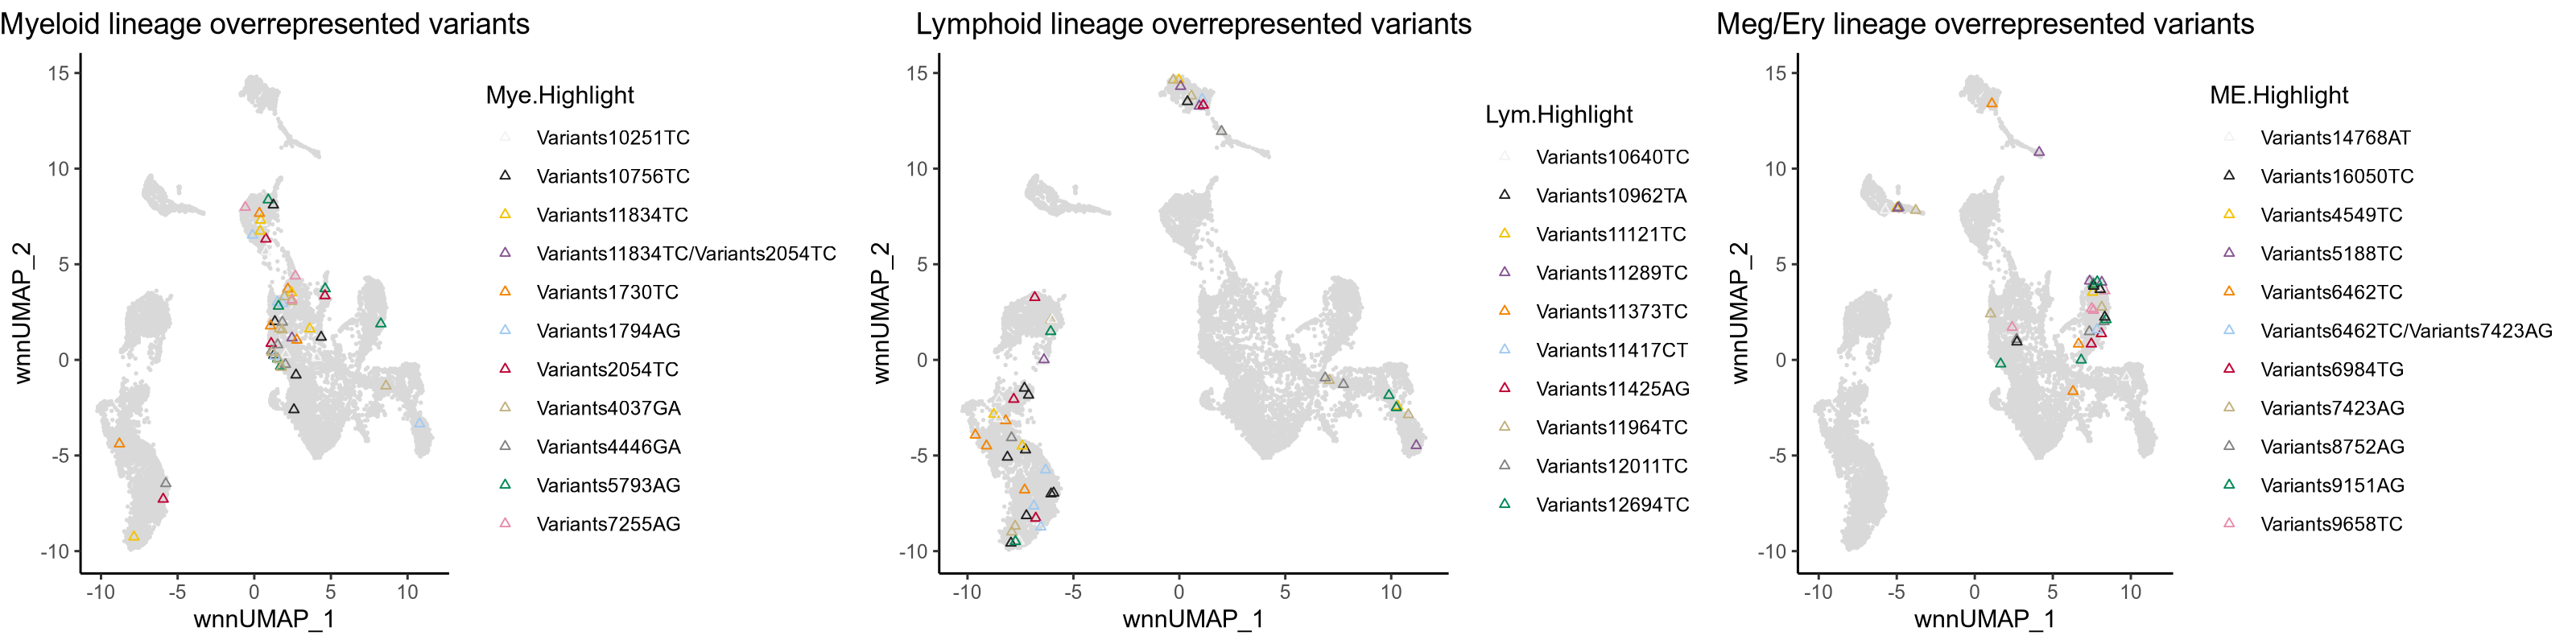

In [25]:
options(repr.plot.width=16, repr.plot.height=4,repr.plot.res=200)
grid.arrange(p1,p2,p3,ncol=3)

## k-nearest neighbor lineage biases

In [26]:
###---
## Define lineage variants
Mye.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$Mye>1.5 & LV.summarise.enrich.pvalues$Mye<0.05),] %>% .[order(.$Mye,decreasing=T),] %>% row.names
Lym.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$Lym>1.5 & LV.summarise.enrich.pvalues$Lym<0.05),] %>% .[order(.$Lym,decreasing=T),] %>% row.names
ME.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$ME>1.5 & LV.summarise.enrich.pvalues$ME<0.05),] %>% .[order(.$ME,decreasing=T),] %>% row.names
MK.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$MKP>1.5 & LV.summarise.enrich.pvalues$MKP<0.05),] %>% .[order(.$MKP,decreasing=T),] %>% row.names


SigV<-data.frame(V=Mye.V,name="V_Mye")  %>% 
rbind(.,data.frame(V=Lym.V,name="V_Lym")) %>% rbind(.,data.frame(V=ME.V,name="V_ME")) %>% rbind(.,data.frame(V=MK.V,name="V_MK")) %>% .[!duplicated(.$V),] 
row.names(SigV)<-SigV$V
Variants<-paste("Variants",gsub("_","",row.names(SigV)),sep="")
nrow(SigV)

[1] 631

In [27]:
## Make the matrix
Variants<-Variants[Variants %in% colnames(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)]
M<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi[,Variants]
M<-M[rowSums(M)>0,]

In [29]:
## Jaccard distance
D<-as.matrix(BinaryDist(M,method = "Jaccard"))

In [31]:
## Make cell type dictionary
CellDic<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta[,"STD.CellType"]  
names(CellDic)<-Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$Cell
table(CellDic)

CellDic
 CD4   NK Mono  CD8 EryP    B ProB  cDC  pDC  MPP  HSC  CLP  GMP  MEP  CMP  MDP 
2070  801  682  892  610  512  739   47   34  751  552  833  892  492  400  461 
 MKP LMPP 
 143   98 

In [194]:
Exp<-colSums(LV.summarise)/colSums(LV.summarise)["sum"]
Exp

Lym        Mye         ME     HSCMPP        MKP        sum 
0.44683654 0.23579579 0.13095419 0.17249475 0.01391872 1.00000000

## Main Fig. 2g

In [35]:
## Generate celltype.mtx which is a cell vs celltype matrix
k=15
od<-c("Mono","MDP","GMP","cDC","EryP","MEP","MKP","HSC","MPP","CMP","pDC","LMPP","CLP","ProB","B","NK","CD8","CD4")
celltype.mtx<-c()
Rnames<-row.names(D)
Cnames<-levels(CellDic)
for (i in 1:ncol(D)){
# i<-sample(1:ncol(test.sensitive.w_j),1)
# print(i)
x<-D[,i] %>% .[order(.)] %>% names %>% .[2:k]
celltype.mtx<-rbind(celltype.mtx,as.numeric(table(CellDic[x])))
}
row.names(celltype.mtx)<-Rnames
colnames(celltype.mtx)<-Cnames
celltype.df<-as.data.frame(celltype.mtx)
celltype.df$Seed=CellDic[Rnames]

In [46]:
# Define NeighbourComp_mean, given a seed celltype, take the mean of the number of a certain target cell type in a k-neighbourhood
NeibourComp_mean<-celltype.df %>% group_by(Seed) %>% dplyr::summarise(MKP=mean(MKP),CMP=mean(CMP),MPP=mean(MPP),HSC=mean(HSC),LMPP=mean(LMPP),Mono=mean(Mono),GMP=mean(GMP),MDP=mean(MDP), cDC=mean(cDC),MEP=mean(MEP),EryP=mean(EryP),ProB=mean(ProB),CLP=mean(CLP),pDC=mean(pDC),B=mean(B),NK=mean(NK),CD8=mean(CD8),CD4=mean(CD4)) 
NeibourComp_mean$Seed<-factor(NeibourComp_mean$Seed,levels=od)

Using Seed as id variables



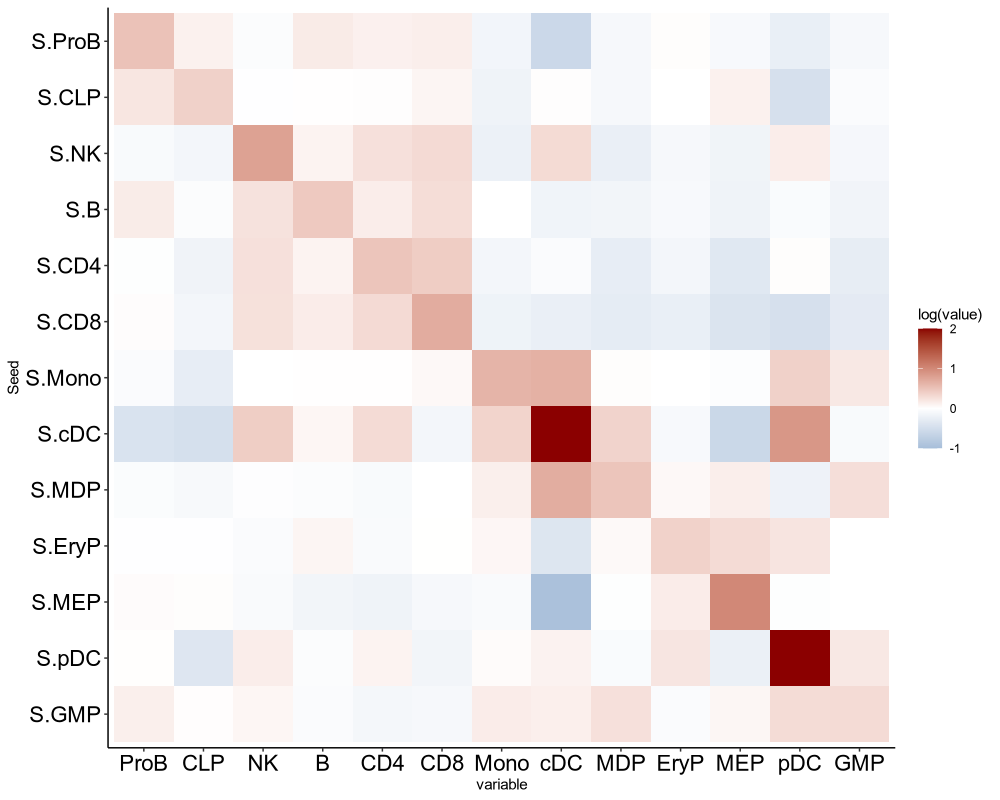

In [44]:
options(repr.plot.width=10, repr.plot.height=8,repr.plot.res=100)
m.normed<-NeibourComp_mean[,2:ncol(NeibourComp_mean)] %>% apply(.,2,function(x){x/median(x)}) %>% cbind(NeibourComp_mean[,1],.)
m.normed$Seed<-paste("S.",m.normed[,1],sep="")
#m.normed
m.normed<-m.normed[!m.normed$Seed %in% c("S.HSC","S.MPP","S.MKP","S.LMPP","S.CMP"),] %>% select(-HSC,-MPP,-LMPP,-MKP,-CMP)
datatoplot<-melt(m.normed)
#head(datatoplot)
## Compute the correlation between rows and make dendrogram
hmod<-m.normed %>% tibble::remove_rownames() %>% tibble::column_to_rownames("Seed") %>% Dist(.,method = "correlation") %>% hclust 
datatoplot$Seed<-factor(datatoplot$Seed,levels=rev(hmod$labels[hmod$order]))
datatoplot$variable<-factor(datatoplot$variable,levels=gsub("S.","",hmod$labels[hmod$order]))
p1<-ggplot(datatoplot)+aes(variable,Seed,fill=log(value))+geom_tile()+scale_fill_gradient2(high="darkred",low="steelblue",mid="white",midpoint=0,na.value = "steelblue",limits=c(-1,2),oob=scales::squish)+
theme_classic()+theme(axis.text = element_text(size=16,color="black"))
print(p1)

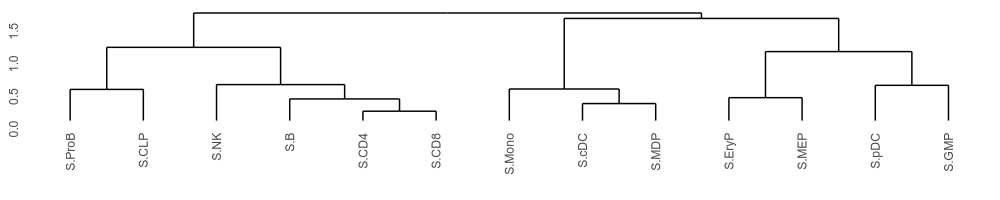

In [53]:
options(repr.plot.width=10, repr.plot.height=2,repr.plot.res=100)
p2<-ggdendrogram(hmod)
print(p2)

# Repeat main analysis on Young-2

In [55]:
Young2_BMMC_HSPC_multiome_seurat<-readRDS(paste(Dir,"/data/Multiome/DN9_BMMC_HSPC_Multiome_wrapper.filtered.anno",sep="")) 

In [56]:
## Standardize cell types
Young2_BMMC_HSPC_multiome_seurat@meta.data<-Young2_BMMC_HSPC_multiome_seurat@meta.data %>% mutate(STD.CellType=ifelse(STD.CellType=="EryP" & Sample=="DN4_HSPC","MEP",as.character(STD.CellType))) %>%
mutate(STD.CellType=ifelse(STD.CellType=="LMPP" & Sample=="DN4_HSPC","MPP",as.character(STD.CellType)))

In [57]:
## Order cell types for color assignment
Young2_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType<-factor(Young2_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType,
levels=c('LMPP','CMP','MPP','HSC','cDC','Gran','MDP','Mono', 'GMP','NK','ProB','CD8','CD4','B','CLP','pDC','MKP','MEP','EryP'))

In [58]:
## Define a common color code
ColorDic<-data.frame(CellType=c('LMPP','CMP','MPP','HSC',
'cDC','Gran','MDP','Mono', 'GMP',
'NK','ProB','CD8','CD4','B','CLP','pDC',
'MKP','MEP','EryP'),
mc=c(brewer.pal(4,"OrRd"),
brewer.pal(5,"YlOrBr"),
brewer.pal(9,"PuBuGn")[3:9],
brewer.pal(3,"PuRd"))
)       
row.names(ColorDic)<-ColorDic$CellType

In [59]:
AvailableLevel<-intersect(levels(Young2_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType),unique(Young2_BMMC_HSPC_multiome_seurat@meta.data$STD.CellType))
mycolor<-ColorDic[AvailableLevel,"mc"]

## Supplementary Fig. 5b

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


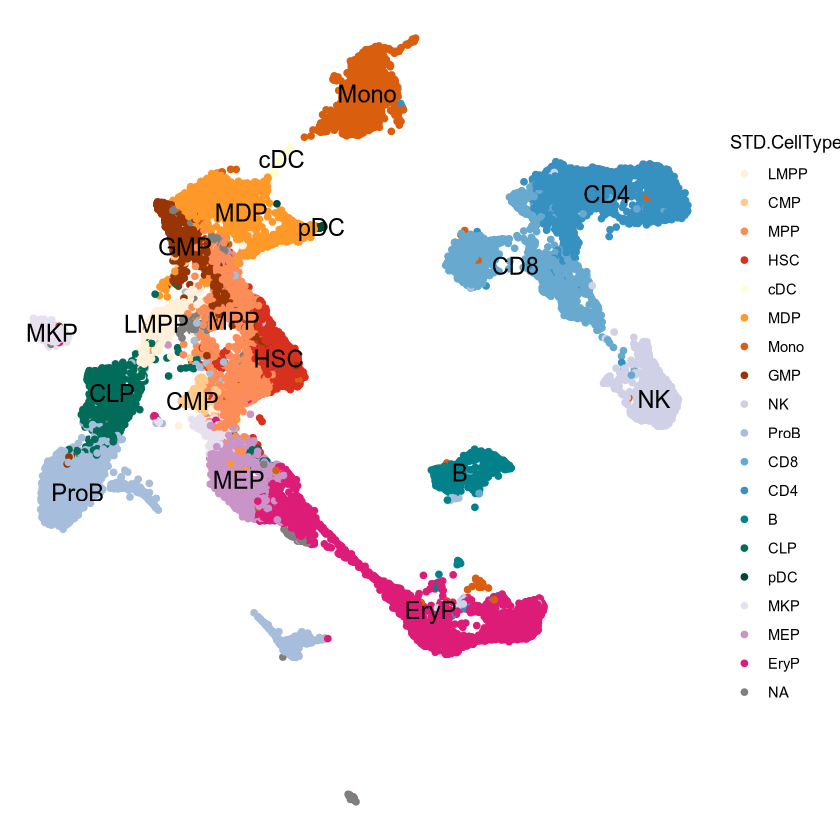

In [60]:
options(repr.plot.width=7, repr.plot.height=7,repr.plot.res=120)
datatoplot<-Tomerge_v2(Young2_BMMC_HSPC_multiome_seurat@reductions$wnn.umap@cell.embeddings,Young2_BMMC_HSPC_multiome_seurat@meta.data[,"STD.CellType",drop=F]) 
label.center<-datatoplot %>% group_by(STD.CellType) %>% dplyr::summarise(x=median(wnnUMAP_1),y=median(wnnUMAP_2))
p<-ggplot(datatoplot)+aes(wnnUMAP_1,wnnUMAP_2,color=STD.CellType)+geom_point(size=1.5) +scale_color_manual(values=mycolor)+theme_void()+geom_text(data=label.center,aes(x=x,y=y,label=STD.CellType),color="black",size=5)#+theme(legend.position="none")
print(p)

In [62]:
## Compute reject rate for normalizing different concensus filtering rate due to sequencing depth
Young2_BMMC_RejectRate<-ComputeRejectRate_legacy(paste(Dir,"/data/redeemV_final/Young2.BMMC.Consensus.final/",sep=""))
Young2_HPC_RejectRate<-ComputeRejectRate_legacy(paste(Dir,"/data/redeemV_final/Young2.HPC.Consensus.final/",sep=""))
Young2_HSC_RejectRate<-ComputeRejectRate_legacy(paste(Dir,"/data/redeemV_final/Young2.HSC.Consensus.final/",sep=""))

This has been deprecated, please use ComputeRejectRate that takes redeemR object as input

This has been deprecated, please use ComputeRejectRate that takes redeemR object as input

This has been deprecated, please use ComputeRejectRate that takes redeemR object as input



In [63]:
Young2_BMMC.HPC.HSC_RejectRate<-rbind(Young2_BMMC_RejectRate %>% mutate(Cell=paste(Cell,"_3",sep="")),
                                   Young2_HPC_RejectRate %>% mutate(Cell=paste(Cell,"_2",sep="")),
                                   Young1_HSC_RejectRate %>% mutate(Cell=paste(Cell,"_1",sep="")))
Young2_BMMC.HPC.HSC_RejectRate<-Young2_BMMC.HPC.HSC_RejectRate %>% tibble::column_to_rownames(var = "Cell")

In [76]:
## Check variant number
## Load processed redeemR object
Young2_HSC_HPC_BMMC_mitoTracing.Sensitive<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN9_HSC_HPC_BMMC_mitoTracing.Sensitive",sep="")) 
CheckVNumber<-Young2_HSC_HPC_BMMC_mitoTracing.Sensitive@Cts.Mtx.bi %>% rowSums %>% Tomerge_v2(Young2_HSC_HPC_BMMC_mitoTracing.Sensitive@CellMeta,.)

In [77]:
CheckVNumber$STD.CellType<-plyr::mapvalues(CheckVNumber$CellType,from=c("HSC", "MPP", "MPP1", "MPP2","MPP3", "MKP", "MKP1","MKP2","MKP3", "EryP", "PreB"),to=c("HSC", "MPP", "MPP", "MPP","MMP", "MKP", "MKP","MKP","MKP", "MEP", "ProB"))
CheckVNumber$STD.CellType<-factor(CheckVNumber$STD.CellType,levels=c("HSC","MKP","MPP","CMP","MEP","LMPP","CLP","GMP","MDP","CDP","ProB","Mono","Meg","Ery","mDC","CD4","CD8","NK","B","pDC"))

The following `from` values were not present in `x`: MPP1, MPP2, MPP3, MKP1, MKP2, MKP3, EryP



In [78]:
CheckVNumber<-subset(CheckVNumber,!STD.CellType %in% c("10","ProB", "CMP", "Meg"))

In [79]:
CheckVNumber$STD_Cat<-recode(CheckVNumber$STD.CellType,
HSC="Stem",
MPP="EarlyP",CMP="EarlyP",MKP="EarlyP",
MEP="Mye_P",GMP="Mye_P",MDP="Mye_P",CDP="Mye_P",
LMPP="Lym_P",CLP="Lym_P",ProB="Lym_P",
Mono="Mye",Ery="Mye",mDC="Mye",
CD4="Lym",CD8="Lym" ,NK="Lym"  ,B="Lym" ,pDC="Lym") 
CheckVNumber$STD_Cat<-factor(CheckVNumber$STD_Cat,levels=c("Stem","EarlyP","Mye_P","Lym_P","Mye","Lym"))

CheckVNumber$STD_Cat2<-recode(CheckVNumber$STD.CellType,
HSC="Stem",
MPP="EarlyP",CMP="EarlyP",MKP="EarlyP",
MEP="LateP",GMP="LateP",MDP="LateP",CDP="LateP",
LMPP="LateP",CLP="LateP",ProB="LateP",
Mono="mature",Ery="mature",mDC="mature",
CD4="mature",CD8="mature" ,NK="mature"  ,B="mature" ,pDC="mature") 
CheckVNumber$STD_Cat2<-factor(CheckVNumber$STD_Cat2,levels=c("Stem","EarlyP","LateP","mature"))

## Supplementary Fig. 5c

In [80]:
## Compute mtDNA mutation burden
CheckVNumber<-Tomerge_v2(CheckVNumber,Young2_BMMC.HPC.HSC_RejectRate) %>% mutate(MutationBurden=100*y/(meanCov*Sensitive))

In [81]:
CheckVNumber<-CheckVNumber[!is.na(CheckVNumber$STD.CellType),]

Warning message:
“Removed 9978 rows containing non-finite values (`stat_boxplot()`).”


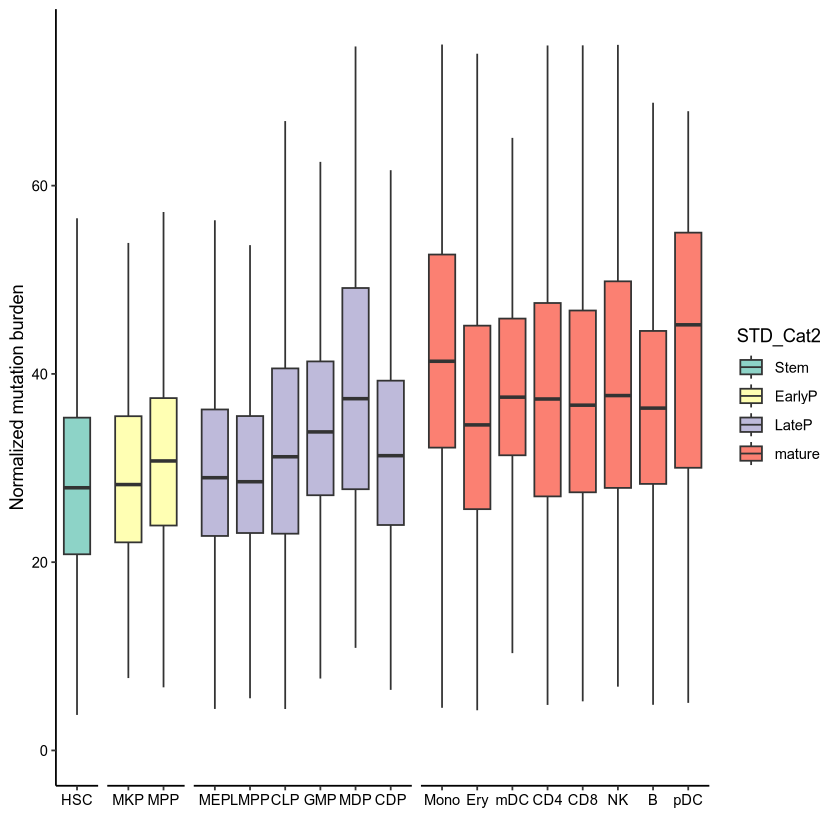

In [82]:
ggplot(CheckVNumber)+aes(STD.CellType,MutationBurden,fill=STD_Cat2)+geom_boxplot(outlier.shape =NA )+ylim(0,75)+
    facet_grid(~STD_Cat2,space = "free",scale="free")+theme_classic()+scale_fill_brewer(palette = "Set3")+theme(strip.text=element_blank(),axis.text = element_text(color="black"),)+labs(x="",y="Normalized mutation burden") 

In [92]:
wilcox.test(subset(CheckVNumber,STD_Cat %in% c("Stem","EarlyP"))$MutationBurden,subset(CheckVNumber,STD_Cat %in% c("Mye_P","Lym_P"))$MutationBurden,alternative = "less")
wilcox.test(subset(CheckVNumber,STD_Cat %in% c("Stem","EarlyP"))$MutationBurden,subset(CheckVNumber,STD_Cat %in% c("Mye","Lym"))$MutationBurden,"less")
wilcox.test(subset(CheckVNumber,STD_Cat %in% c("Mye_P","Lym_P"))$MutationBurden,subset(CheckVNumber,STD_Cat %in% c("Mye","Lym"))$MutationBurden,"less")


	Wilcoxon rank sum test with continuity correction

data:  subset(CheckVNumber, STD_Cat %in% c("Stem", "EarlyP"))$MutationBurden and subset(CheckVNumber, STD_Cat %in% c("Mye_P", "Lym_P"))$MutationBurden
W = 5959768, p-value = 5.646e-12
alternative hypothesis: true location shift is less than 0



	Wilcoxon rank sum test with continuity correction

data:  subset(CheckVNumber, STD_Cat %in% c("Stem", "EarlyP"))$MutationBurden and subset(CheckVNumber, STD_Cat %in% c("Mye", "Lym"))$MutationBurden
W = 4941563, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0



	Wilcoxon rank sum test with continuity correction

data:  subset(CheckVNumber, STD_Cat %in% c("Mye_P", "Lym_P"))$MutationBurden and subset(CheckVNumber, STD_Cat %in% c("Mye", "Lym"))$MutationBurden
W = 17293948, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0


In [83]:
## Load processed redeemR object
Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN9_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p",sep="")) 

In [84]:
tree<-ggtree(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,branch.length='none')
CellOrder<-subset(tree$data,isTip==TRUE) %>% .[order(.$y),] %>% .$label
VN.summary<-data.frame(VN=rowSums(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)) %>% tibble::rownames_to_column("Cell") %>% mutate(Cell=factor(CellOrder,levels=CellOrder)) %>% mutate(Cell=factor(CellOrder,levels=CellOrder))

## Supplementary Fig. 5a

In [85]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=80)
p<-ggtree(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata,branch.length='none',layout="fan",open.angle = 10)+
geom_fruit(data=VN.summary,mapping=aes(y=Cell,
                                           x=VN),
                                           orientation="y",
                                           stat="identity",axis.params=list(axis="x",text.size=6),
                                           geom=geom_bar,pwidth=0.65, fill="gold")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


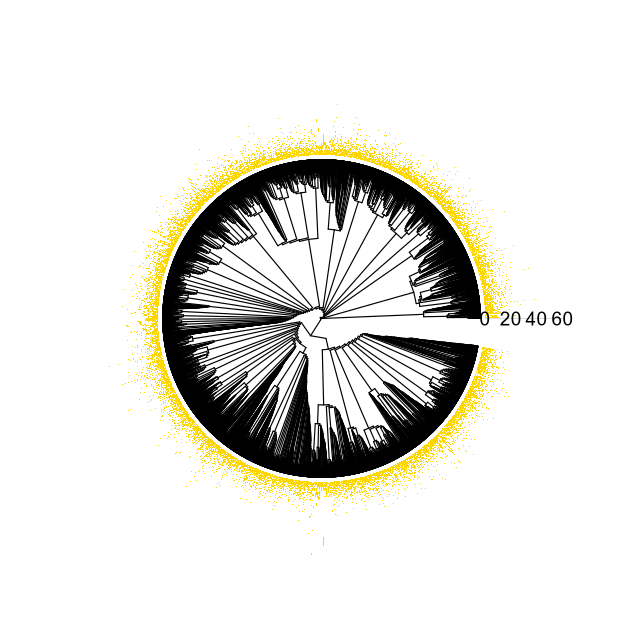

In [86]:
print(p)

In [87]:
## Compute the Expect cell type proportion
Expect<-table(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$STD.CellType) %>% prop.table
Expect


         CD4         Mono          CD8         EryP           NK            B 
0.1320442355 0.0774120919 0.1044963910 0.0982716376 0.0355605589 0.0440368188 
        ProB       Plasma          cDC          pDC          CLP          MEP 
0.1106549235 0.0036421429 0.0033110390 0.0009933117 0.0526455202 0.0535726111 
         MDP          HSC          MPP         LMPP          GMP          MKP 
0.0662207801 0.0469505331 0.0739023906 0.0275478445 0.0370174161 0.0214555327 
         CMP      unknown 
0.0102642209 0.0000000000 

In [88]:
## Get unique clades
Unique_Clades<-unique(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$edge[,1])
## Get decendent leaves for each clades
Unique_Clades_Des<-phangorn::Descendants(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo,Unique_Clades,)
## Get decendent cell names for each clades
Unique_Clades_Des_CellNames<-lapply(Unique_Clades_Des,function(x){Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$tip.label[x]}) 
## Get clade sizes
Unique_Clades_Sizes<-data.frame(Clades=Unique_Clades,CladeSize=sapply(Unique_Clades_Des,length))

In [91]:
## Compute the lineage enrichment at tree clade level
clade_lineage_summary<-list()
for(Focus in c("CD4","CD8","NK","B","ProB","CLP","Mono","GMP","MDP","MEP","EryP")){
FCs<-c()
pvalues<-c()
for (i in 1:length(Unique_Clades_Des_CellNames)){
    cells<-Unique_Clades_Des_CellNames[[i]]
    data<-subset(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta,Cell %in% cells)
    x=length(which(data$STD.CellType==Focus))
    n=nrow(data)
    Fold=(x/n)/Expect[Focus]
    md<-binom.test(x,n,Expect[Focus],alternative = "greater")
    pvalue<-md$p.value
    FCs<-c(FCs,Fold)
    pvalues=c(pvalues,pvalue)
}
summary<-data.frame(Clades=Unique_Clades,FCs=FCs,pvalues=pvalues)
clade_lineage_summary<-c(clade_lineage_summary,list(summary))
}
names(clade_lineage_summary)<-c("CD4","CD8","NK","B","ProB","CLP","Mono","GMP","MDP","MEP","EryP")
clade_lineage_summary<-lapply(clade_lineage_summary,function(x){merge(x,Unique_Clades_Sizes,by="Clades")})

In [93]:
## Add FDR
for(i in 1:length(clade_lineage_summary)){
    clade_lineage_summary[[i]]<-clade_lineage_summary[[i]] %>% subset(.,FCs!=0) %>% mutate(FDRs=qvalue(.[,"pvalues"])$qvalues) 
}

## Merge
merge_clade_lineage_summary<-c()
for (i in 1:length(clade_lineage_summary)){
    tmp<-clade_lineage_summary[[i]] %>% mutate(CellType=names(clade_lineage_summary)[[i]])
    merge_clade_lineage_summary<-rbind(merge_clade_lineage_summary,tmp)
}

## Supplementary Data 3

In [141]:
## Define "linegae", in this context, "lineage" is a differentaion trajectory, such as lymphoind, myeloid, etc
Young2_meta<-Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta
Young2_meta$Lineage<-dplyr::recode(Young2_meta$STD.CellType,
MK="MKP", 
EryP ="ME",MEP="ME",
HSC="HSCMPP", MPP="HSCMPP",LMPP="HSCMPP", CMP="HSCMPP",
MDP="Mye", GMP="Mye",cDC="Mye", Mono="Mye",
ProB="Lym", CLP="Lym", pDC="Lym",B="Lym", NK="Lym", CD8="Lym", CD4="Lym","Plasma"="Lym")

In [142]:
table(Young2_meta$Lineage)


    Lym     Mye      ME  HSCMPP     MKP unknown 
   7310    2778    2293    2396     324       0 

In [143]:
# Compute lineage variants summary
LV<-Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@GTsummary.filtered %>% merge(.,Young2_meta[,c("Cell","Lineage")]) 
## Make LV.summarise
LV.summarise<-LV %>% group_by(Variants) %>% dplyr::count(Lineage) %>% dcast(Variants~Lineage)
row.names(LV.summarise)<-LV.summarise$Variants
LV.summarise<-LV.summarise[,-1]
LV.summarise[is.na(LV.summarise)]<-0
LV.summarise$sum<-rowSums(LV.summarise)
head(LV.summarise,n=2)

Using n as value column: use value.var to override.



,Lym,Mye,ME,HSCMPP,MKP,sum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000_T_C,7,1,2,2,0,12
10000_G_A,12,7,3,4,0,26


In [144]:
merge_clade_lineage_summary.report<-subset(merge_clade_lineage_summary,FDRs<=0.25 & FCs>2 & CladeSize>=4)

In [147]:
merge_clade_lineage_summary.report %>% .[order(.$FDR),] %>% head # We manually picked some examples from this table and visulized below

,Clades,FCs,pvalues,CladeSize,FDRs,CellType
,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>
60012,15579,4.454441,3.902882e-05,29,0.03387342,Mono
82312,15802,4.844204,4.446124e-05,24,0.03387342,Mono
124212,16221,6.458939,3.505602e-05,14,0.03387342,Mono
2338,15212,3.515130,3.618812e-03,56,0.05256700,NK
4076,15386,2.713434,2.557967e-03,114,0.05256700,NK
5106,15489,4.440165,2.095747e-03,38,0.05256700,NK


In [148]:
## Calculate expected lineage proportion
Exp<-colSums(LV.summarise[,-6])/sum(colSums(LV.summarise[,-6]))
Exp

Lym        Mye         ME     HSCMPP        MKP 
0.38923168 0.23360697 0.18218255 0.17300816 0.02197064

In [149]:
## A function to test lineage biases
VariantLinBiase.compute<-function(x,alt="greater"){
p1<-binom.test(x[1],x[6],Exp[1],alternative = alt)$p.value
Es1<-(x[1]/x[6])/Exp[1]
p2<-binom.test(x[2],x[6],Exp[2],alternative = alt)$p.value
Es2<-(x[2]/x[6])/Exp[2]
p3<-binom.test(x[3],x[6],Exp[3],alternative = alt)$p.value
Es3<-(x[3]/x[6])/Exp[3]
p4<-binom.test(x[4],x[6],Exp[4],alternative = alt)$p.value
Es4<-(x[4]/x[6])/Exp[4]
p5<-binom.test(x[5],x[6],Exp[5],alternative = alt)$p.value
Es5<-(x[5]/x[6])/Exp[5]
ps<-c(p1,p2,p3,p4,p5)
Ess<-c(Es1,Es2,Es3,Es4,Es5)
return(list(ps,Ess))
}

In [150]:
## Compute lineage enrichment for all mtDNA mutations
LV.summarise.raw<-apply(LV.summarise,1,VariantLinBiase.compute)
LV.summarise.enrich.pvalues<- lapply(LV.summarise.raw,function(x){x[[1]]}) %>% do.call(rbind,.) %>% as.data.frame
LV.summarise.enrich.effectSizes<-lapply(LV.summarise.raw,function(x){x[[2]]}) %>% do.call(rbind,.)  %>% as.data.frame

In [152]:
###---
## Define lineage variants
Mye.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$Mye>1.5 & LV.summarise.enrich.pvalues$Mye<0.05),] %>% .[order(.$Mye,decreasing=T),] %>% row.names
Lym.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$Lym>1.5 & LV.summarise.enrich.pvalues$Lym<0.05),] %>% .[order(.$Lym,decreasing=T),] %>% row.names
ME.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$ME>1.5 & LV.summarise.enrich.pvalues$ME<0.05),] %>% .[order(.$ME,decreasing=T),] %>% row.names
MK.V<-LV.summarise.enrich.effectSizes[which(LV.summarise.enrich.effectSizes$MKP>1.5 & LV.summarise.enrich.pvalues$MKP<0.05),] %>% .[order(.$MKP,decreasing=T),] %>% row.names


SigV<-data.frame(V=Mye.V,name="V_Mye")  %>% 
rbind(.,data.frame(V=Lym.V,name="V_Lym")) %>% rbind(.,data.frame(V=ME.V,name="V_ME")) %>% rbind(.,data.frame(V=MK.V,name="V_MK")) %>% .[!duplicated(.$V),] 
row.names(SigV)<-SigV$V
Variants<-paste("Variants",gsub("_","",row.names(SigV)),sep="")
nrow(SigV)

[1] 720

In [153]:
## Make the matrix
Variants<-Variants[Variants %in% colnames(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi)]
M<-Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@Cts.Mtx.bi[,Variants]
M<-M[rowSums(M)>0,]

In [154]:
## Jaccard distance
D<-as.matrix(BinaryDist(M,method = "Jaccard"))

In [155]:
## Make cell type dictionary
CellDic<-Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta[,"STD.CellType"]  
names(CellDic)<-Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$Cell
table(CellDic)

CellDic
    CD4    Mono     CD8    EryP      NK       B    ProB  Plasma     cDC     pDC 
   1994    1169    1578    1484     537     665    1671      55      50      15 
    CLP     MEP     MDP     HSC     MPP    LMPP     GMP     MKP     CMP unknown 
    795     809    1000     709    1116     416     559     324     155       0 

In [156]:
Exp<-colSums(LV.summarise)/colSums(LV.summarise)["sum"]
Exp

Lym        Mye         ME     HSCMPP        MKP        sum 
0.38923168 0.23360697 0.18218255 0.17300816 0.02197064 1.00000000

## Supplementary Fig. 5e

In [157]:
## Generate celltype.mtx which is a cell vs celltype matrix
k=15
od<-c("Mono","MDP","GMP","cDC","EryP","MEP","MKP","HSC","MPP","CMP","pDC","LMPP","CLP","ProB","B","NK","CD8","CD4")
celltype.mtx<-c()
Rnames<-row.names(D)
Cnames<-levels(CellDic)
for (i in 1:ncol(D)){
# i<-sample(1:ncol(test.sensitive.w_j),1)
# print(i)
x<-D[,i] %>% .[order(.)] %>% names %>% .[2:k]
celltype.mtx<-rbind(celltype.mtx,as.numeric(table(CellDic[x])))
}
row.names(celltype.mtx)<-Rnames
colnames(celltype.mtx)<-Cnames
celltype.df<-as.data.frame(celltype.mtx)
celltype.df$Seed=CellDic[Rnames]

In [158]:
# Define NeighbourComp_mean, given a seed celltype, take the mean of the number of a certain target cell type in a k-neighbourhood
NeibourComp_mean<-celltype.df %>% group_by(Seed) %>% dplyr::summarise(MKP=mean(MKP),CMP=mean(CMP),MPP=mean(MPP),HSC=mean(HSC),LMPP=mean(LMPP),Mono=mean(Mono),GMP=mean(GMP),MDP=mean(MDP), cDC=mean(cDC),MEP=mean(MEP),EryP=mean(EryP),ProB=mean(ProB),CLP=mean(CLP),pDC=mean(pDC),B=mean(B),NK=mean(NK),CD8=mean(CD8),CD4=mean(CD4)) 
NeibourComp_mean$Seed<-factor(NeibourComp_mean$Seed,levels=od)

Using Seed as id variables



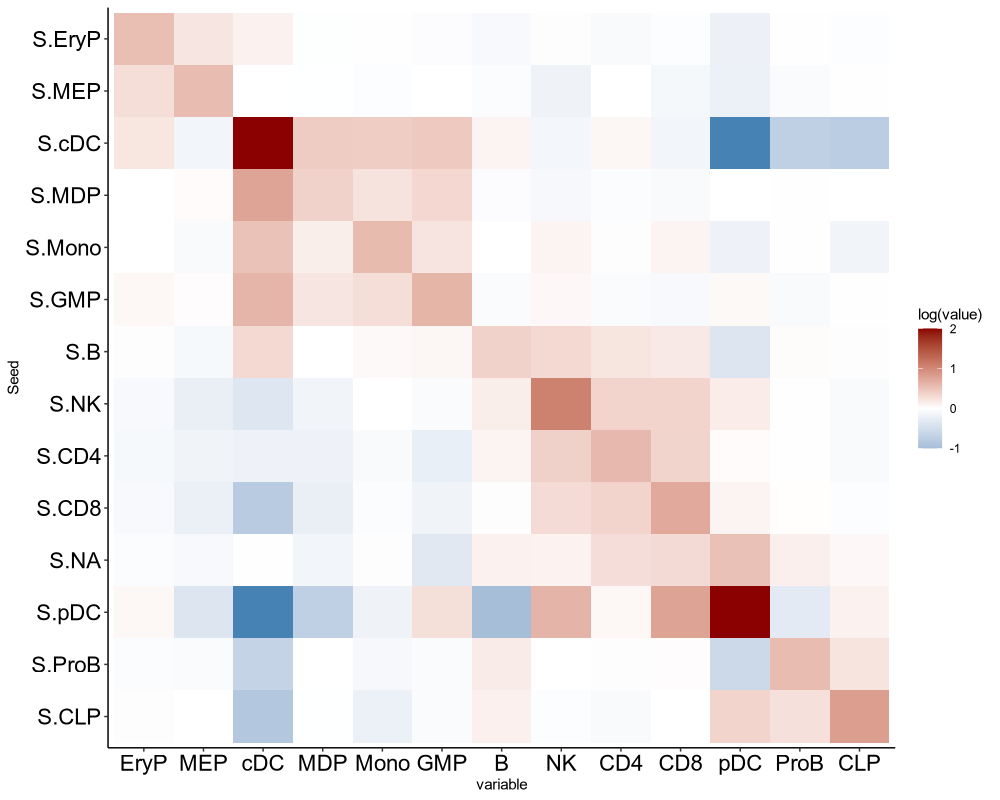

In [159]:
options(repr.plot.width=10, repr.plot.height=8,repr.plot.res=100)
m.normed<-NeibourComp_mean[,2:ncol(NeibourComp_mean)] %>% apply(.,2,function(x){x/median(x)}) %>% cbind(NeibourComp_mean[,1],.)
m.normed$Seed<-paste("S.",m.normed[,1],sep="")
#m.normed
m.normed<-m.normed[!m.normed$Seed %in% c("S.HSC","S.MPP","S.MKP","S.LMPP","S.CMP"),] %>% select(-HSC,-MPP,-LMPP,-MKP,-CMP)
datatoplot<-melt(m.normed)
#head(datatoplot)
## Compute the correlation between rows and make dendrogram
hmod<-m.normed %>% tibble::remove_rownames() %>% tibble::column_to_rownames("Seed") %>% Dist(.,method = "correlation") %>% hclust 
datatoplot$Seed<-factor(datatoplot$Seed,levels=rev(hmod$labels[hmod$order]))
datatoplot$variable<-factor(datatoplot$variable,levels=gsub("S.","",hmod$labels[hmod$order]))
p1<-ggplot(datatoplot)+aes(variable,Seed,fill=log(value))+geom_tile()+scale_fill_gradient2(high="darkred",low="steelblue",mid="white",midpoint=0,na.value = "steelblue",limits=c(-1,2),oob=scales::squish)+
theme_classic()+theme(axis.text = element_text(size=16,color="black"))
print(p1)